In [3]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

## Prepare data

In [4]:
x = loadmat('Signals_S')
y = loadmat("Labels_T")

In [5]:
x = x['S']
y = y['T']

In [6]:
x = x.T
y = y.reshape(200, -1)
y = y.T

Standardize inputs

In [7]:
mean = np.mean(x, 0, keepdims=True)
std = np.std(x, 0, keepdims=True)

x = (x - mean) / std

In [8]:
class DiffusionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __getitem__(self, index):
        return self.x[index, :], self.y[index, :]

    def __len__(self):
        return self.x.shape[0]
    
def get_idx(n, train_val_test_fractions):
    index = np.arange(0, n)
    np.random.shuffle(index)

    train_val_test_fractions /= np.sum(train_val_test_fractions)
    split_locations = (np.cumsum(train_val_test_fractions[:-1]) * n).astype(int)
    train_idx, val_idx, test_idx = np.split(index, split_locations)
    return train_idx, val_idx, test_idx

In [9]:
n = x.shape[0]
train_idx, val_idx, test_idx = get_idx(n, [0.8, 0.1, 0.1])

data_train = DiffusionDataset(x[train_idx, :], y[train_idx, :])
data_val = DiffusionDataset(x[val_idx, :], y[val_idx, :])
data_test = DiffusionDataset(x[test_idx, :], y[test_idx, :])

n_batch = 1000
loader_train = DataLoader(data_train, batch_size=n_batch, shuffle=True)
loader_val = DataLoader(data_val, batch_size=n_batch, shuffle=False)
loader_test = DataLoader(data_test, batch_size=n_batch, shuffle=False)

## Define neural network

In [10]:
from torch.nn import ModuleList, Linear, LeakyReLU, MSELoss

class MLP(torch.nn.Module):

    def __init__(self, n_channels, act=LeakyReLU()):
      super().__init__()

      self.layers = torch.nn.ModuleList()
      for i in range(0, len(n_channels) - 1):
        if i > 0:
          self.layers.append(act)
        self.layers.append(Linear(n_channels[i], n_channels[i+1])) 

    def forward(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

loss_fn = MSELoss()

In [11]:
# To support GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
net = MLP([2000, 1000, 500, 200]) # First is input dim and last is output dim
net.to(device)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=500, out_features=200, bias=True)
  )
)

## Train

In [25]:
n_epochs = 50
loss_train = []
loss_val = []

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)


for epoch in range(n_epochs):

  net.train()
  running_loss = 0.0

  for batch_index, batch in enumerate(loader_train):
    x, y = batch
    x.to(device)
    y.to(device)
    
    pred = net(x)
    loss = loss_fn(pred, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_train.append(running_loss / (batch_index + 1))

  net.eval()
  running_loss = 0.0
  for batch_index, batch in enumerate(loader_val):
    x, y = batch
    x.to(device)
    y.to(device)
    
    pred = net(x)      
    loss = loss_fn(pred, y) 

    running_loss += loss.item()

  loss_val.append(running_loss / (batch_index + 1))

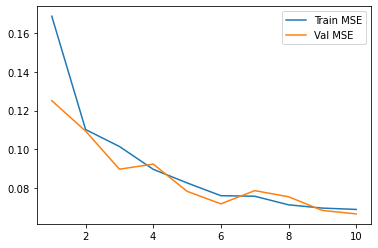

In [26]:
plt.plot(np.arange(n_epochs) + 1, loss_train, label='Train MSE')
plt.plot(np.arange(n_epochs) + 1, loss_val, label='Val MSE')
plt.legend()

## Making it work well
1. With noise-free data you should be able to get almost a perfect score on the training data. Make the network deeper/wider until you do. Also consider tuning the learning rate.
2. When you successfully over-fit on the training data, add regularization e.g. dropout and weight decay.
3. When you successfully fit both the training and validation data, add appropriate noise to the data.